#HW2 - Algorithm Implementation and Basic Model Selection 

##Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##Adjusting Default Font Size

In [ ]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

## Loading the dataset

In [ ]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


#Preliminary: Data Loading

In [ ]:
dataset = pd.read_csv(filename)

In [ ]:
#We preform the preprocessing here using our prepare function from HW1
pd.set_option('display.max_columns', None)
dataset = pd.read_csv(filename)
from sklearn.model_selection import train_test_split
#Splitting the data into 'train' and 'test'
train_df, test_df = train_test_split(dataset, test_size = 0.2, train_size = 0.8,
                                     random_state = 122)

In [ ]:
#Our corrected prepare function - follows {1, -1} convention and doesn't remove the mentioned important features

def prepare_data(data, training_data):
  #we use clean_data() and data_imputation_training_data() to extract the "median_l" and "most_common_l"
  training_data_copy = training_data  
  training_data_copy = clean_data(training_data_copy)
  training_data_copy, most_common_l, median_l = data_imputation_training_data(training_data_copy)

  #In the original func in HW1 we used the following two aux-functions but it's apparently unnecessary 
  #training_data_copy = Data_Normalization(training_data_copy)
  #training_data_copy = data_Selection(training_data_copy)

  data_copy = data  
  data_copy = clean_data(data_copy)
  data_copy = data_imputation_test(data_copy, most_common_l, median_l)
  data_copy = Data_Normalization(data_copy)

  data_copy = data_Selection(data_copy)

  #All target variables follow the {+1,-1} convention (rather than {1,0} or {True,False})
  data_copy = zero_to_minus_one_convention(data_copy)

  return data_copy

def clean_data(data):
  data.risk = data.risk.replace({'High': 1, 'Low': -1})
  blood_type_one_hot = pd.get_dummies(data['blood_type'])
  data = data.join(blood_type_one_hot)
  data.drop('blood_type' , axis = 1 , inplace = True)
  symptoms_one_hot = data['symptoms'].str.get_dummies(sep=';')
  data = data.join(symptoms_one_hot)
  data.drop('symptoms' , axis = 1 , inplace = True)
  data['sex'].replace({'F': 1, 'M' :-1} , inplace = True)
  data['spread'].replace({'High': 1, 'Low' :-1}, inplace = True)
  data['covid'].replace({True: 1, False: -1}, inplace = True)
  data[["pcr_day", "pcr_month", "pcr_year"]] = data["pcr_date"].str.split("-", expand = True)
  data.drop('pcr_date' , axis = 1 , inplace = True)
  data['current_location'] = data['current_location'].str.strip("()'")
  data[["current_location_latitude", "current_location_longitude"]] = \
    data["current_location"].str.split("', '", expand = True)
  data.drop('current_location' , axis = 1 , inplace = True)
  data.drop('address' , axis = 1 , inplace = True)

  return data

def data_imputation_training_data(data):
  most_common_l = []
  median_l = []

  train = data
  cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'happiness_score', \
                                      'conversations_per_day', 'sugar_levels', 'sport_activity', \
                                      'PCR_03', 'pcr_day', 'pcr_month', 'pcr_year']
  cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', \
                                  'PCR_06', 'PCR_07', 'PCR_09', 'current_location_latitude', \
                                  'current_location_longitude']

  for col in cols_missing_data_non_continuous:
    most_common = train[col].value_counts().idxmax()
    most_common_l.append(most_common)
    train[col].fillna(most_common, inplace = True)

  for col in cols_missing_data_continuous:
    median = train[col].median(skipna = True)
    median_l.append(median)
    train[col].fillna(median, inplace = True)

  return train, most_common_l, median_l

def data_imputation_test(test, most_common_l, median_l):
  train = test
  cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'happiness_score', \
                                      'conversations_per_day', 'sugar_levels', 'sport_activity', \
                                      'PCR_03', 'pcr_day', 'pcr_month', 'pcr_year']
  cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', \
                                  'PCR_06', 'PCR_07', 'PCR_09', 'current_location_latitude', \
                                  'current_location_longitude']

  for index, col in enumerate(cols_missing_data_non_continuous):
    train[col].fillna(most_common_l[index], inplace = True)

  for index, col in enumerate(cols_missing_data_continuous):
    train[col].fillna(median_l[index], inplace = True)

  return train

def Data_Normalization(data):
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler

  train = data
  cols_to_minmax = ['sex', 'O+', 'O-', 'A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'num_of_siblings', \
                    'happiness_score', 'conversations_per_day', 'sport_activity', 'PCR_03', \
                    'cough', 'fever', 'low_appetite', 'shortness_of_breath', 'sore_throat']

  features = train[cols_to_minmax]
  scaler = MinMaxScaler().fit(features.values)
  features = scaler.transform(features.values)

  train[cols_to_minmax] = features

  cols_to_standard = ['patient_id', 'age', 'weight', 'current_location_latitude', 'current_location_longitude', 
                      'household_income', 'sugar_levels', 'PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 
                      'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'pcr_day', 'pcr_month', 'pcr_year']
                      
  features = train[cols_to_standard]

  scaler = StandardScaler().fit(features.values)
  features = scaler.transform(features.values)

  train[cols_to_standard] = features

  return train

def data_Selection(data):
  #in the original function on HW1 we also deleted "pcr_01"
  columns_to_drop = ['patient_id', 'age', 'weight', 'num_of_siblings', 'household_income', \
                     'conversations_per_day', 'PCR_02', 'PCR_03', 'PCR_07', 'PCR_09', 'AB+', \
                     'AB-', 'B+', 'B-', 'fever', 'pcr_day', 'current_location_latitude', \
                     'current_location_longitude', 'happiness_score']
  data = data.drop(columns_to_drop , axis = 1)
  return data

def zero_to_minus_one_convention(data):
  cols_to_change = []
  for col in data.columns:
    if data[col].isin([0,1]).all():
      cols_to_change.append(col)
      data[col].replace({0: -1}, inplace = True)
  return data



In [ ]:
# Clean training set according to itself
train_df_clean = prepare_data(train_df, train_df)
# Clean test set according to the raw training set
test_df_clean = prepare_data(test_df, train_df)

#Part 1: Basic model selection with k-Nearest Neighbors

##Visualization and basic analysis

###Q1

Text(0.5, 1.05, 'Bivariant Relation between PCR_08, PCR_10 and risk features')

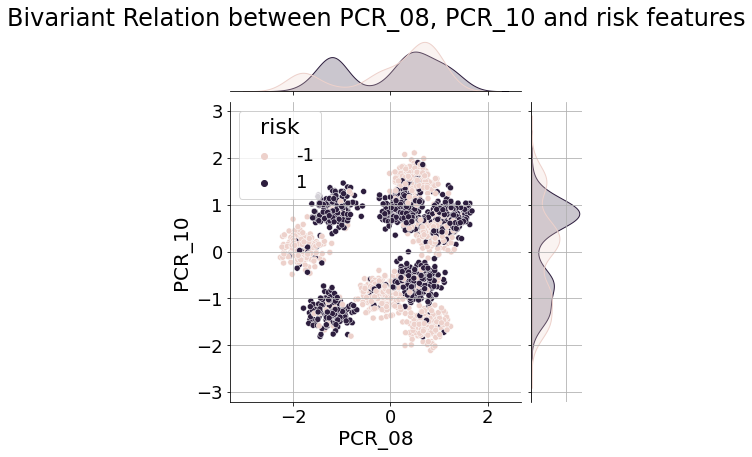

In [ ]:
#Plotting a jointplot for PCR_08, PCR_10 and risk

temp_train = train_df_clean[['PCR_08', 'PCR_10', 'risk']]
j_plot = sns.jointplot(data = temp_train, x = 'PCR_08', y = 'PCR_10', hue = 'risk')
_ = j_plot.ax_joint.grid()
plt.grid()
plt.suptitle("Bivariant Relation between PCR_08, PCR_10 and risk features", y=1.05)

###Q2

In [ ]:
#The provided visualize_clf function

def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=80,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # Make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    #plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()
   

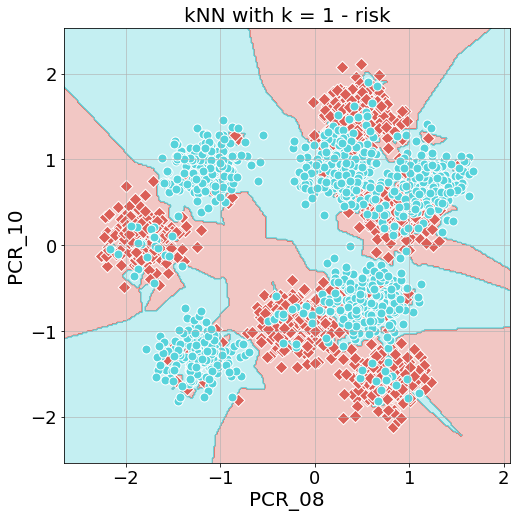

In [ ]:
from copy import copy

#creating temp dataframe
temp_train = copy(train_df_clean[['PCR_08', 'PCR_10']].values)
temp_labels = copy(train_df_clean.risk.values)

#Training and visualizing kNN model with k = 1
from sklearn.neighbors import KNeighborsClassifier
knn_inst_1 = KNeighborsClassifier(n_neighbors = 1)
x = temp_train
y = temp_labels
knn_inst_1.fit(x,y)
visualize_clf(knn_inst_1, x, y, "kNN with k = 1 - risk", "PCR_08", "PCR_10")

##Model selection

###Q3

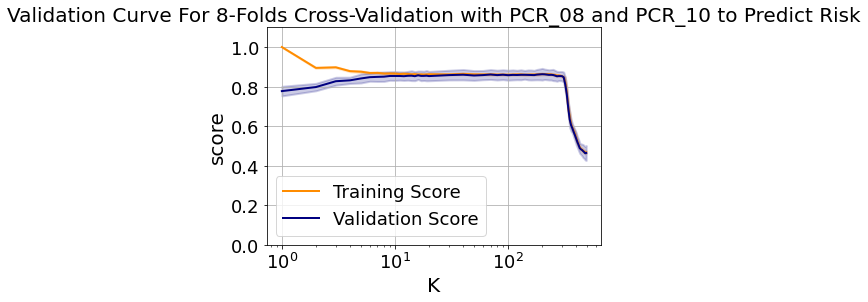

best k value is 200 , its train accuracy is 0.8636428571428572and its validation accuracy is 0.8625


In [ ]:
from sklearn.model_selection import cross_validate

#Preparing arrays to store results from cross validation
values_list = list(range(1, 20, 1)) + list(range(20, 500, 10))
train_scores_mean = []
train_scores_std = []
validation_scores_mean = []
validation_scores_std = []

temp_train = copy(train_df_clean[['PCR_08', 'PCR_10']].values)
temp_labels = copy(train_df_clean.risk.values)

#Preforming 8-folds cross validation with all provided k values
for num in values_list:
  knn_inst = KNeighborsClassifier(n_neighbors = num)
  cv_results = cross_validate(knn_inst, temp_train, temp_labels, cv = 8, return_train_score = True)
  train_scores_mean.append(np.mean(cv_results['train_score']))
  validation_scores_mean.append(np.mean(cv_results['test_score']))
  train_scores_std.append(np.std(cv_results['train_score']))
  validation_scores_std.append(np.std(cv_results['test_score']))

#Plotting the validation curve  
plt.title("Validation Curve For 8-Folds Cross-Validation with PCR_08 and PCR_10 to Predict Risk", fontsize = 20)
plt.xlabel('K')
plt.ylabel('score')
plt.ylim(0.0, 1.1)
plt.semilogx(
    values_list, train_scores_mean, label="Training Score", color="darkorange", lw=2
    )
plt.fill_between(
    values_list,
    np.subtract(np.array(train_scores_mean), np.array(train_scores_std)),
    np.add(np.array(train_scores_mean), np.array(train_scores_std)),
    alpha=0.2,
    color="darkorange",
    lw=2,
    )
plt.semilogx(
    values_list, validation_scores_mean, label="Validation Score", color="navy", lw=2
    )
plt.fill_between(
    values_list,
    np.subtract(np.array(validation_scores_mean), np.array(validation_scores_std)),
    np.add(np.array(validation_scores_mean), np.array(validation_scores_std)),
    alpha=0.2,
    color="navy",
    lw=2,
    )
plt.legend(loc="best")
plt.grid(visible = True)
plt.show()

#Calculating training and validation accuracies, and the optimal value for k
best_validation_accuracy = np.max(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_k = values_list[best_validation_accuracy_index]
print("best k value is "+str(best_k)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

###Q4 + Q5

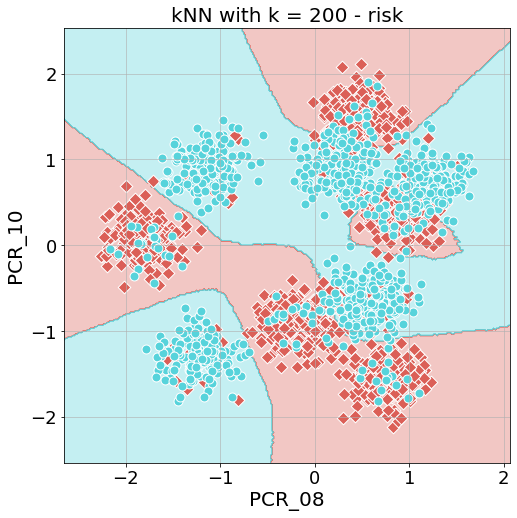

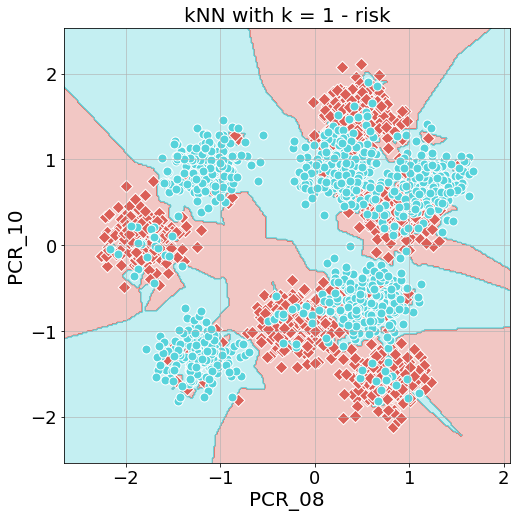

Test score of k=200 is  0.85


In [ ]:
#Creating and training a knn model with k = 200 (our optimal hyperparameter)
temp_train = copy(train_df_clean[['PCR_08', 'PCR_10']].values)
temp_train_labels = copy(train_df_clean.risk.values)
temp_test = copy(test_df_clean[['PCR_08', 'PCR_10']].values)
temp_test_labels = copy(test_df_clean.risk.values)

knn_inst_200 = KNeighborsClassifier(n_neighbors = 200)
x = temp_train
y = temp_train_labels
knn_inst_200.fit(x,y)

#Visualizing kNN model with k = 200
visualize_clf(knn_inst_200, x, y, "kNN with k = 200 - risk", "PCR_08", "PCR_10")

#Visualizing kNN model with k = 1
visualize_clf(knn_inst_1, temp_train, temp_train_labels, "kNN with k = 1 - risk", "PCR_08", "PCR_10")

print("Test score of k=200 is ", knn_inst_200.score(temp_test, temp_test_labels))

###Q6

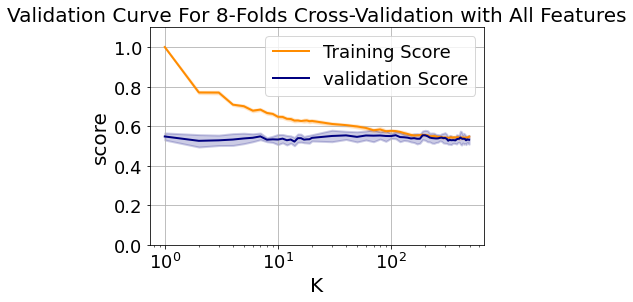

best k value is 110 , its train accuracy is 0.5747857142857142and its validation accuracy is 0.554


In [ ]:
from sklearn.model_selection import cross_validate

#Creating a temporary dataframe for training
temp_train = copy(train_df_clean)
temp_train.drop('risk' , axis = 1 , inplace = True)
temp_train.drop('covid' , axis = 1 , inplace = True)
temp_train.drop('spread' , axis = 1 , inplace = True)
temp_labels = copy(train_df_clean.risk.values)

#Preparing arrays to store results from cross validation
values_list = list(range(1, 20, 1)) + list(range(20, 500, 10))
train_scores_mean = []
train_scores_std = []
validation_scores_mean = []
validation_scores_std = []

#Preforming 8-folds cross validation with all provided k values
for index, num in enumerate(values_list):
  knn_inst = KNeighborsClassifier(n_neighbors = num)
  cv_results = cross_validate(knn_inst, temp_train, temp_labels, cv = 8, return_train_score = True)
  train_scores_mean.append(np.mean(cv_results['train_score']))
  validation_scores_mean.append(np.mean(cv_results['test_score']))
  train_scores_std.append(np.std(cv_results['train_score']))
  validation_scores_std.append(np.std(cv_results['test_score']))

#Plotting the validation curve  
plt.title("Validation Curve For 8-Folds Cross-Validation with All Features", fontsize = 20)
plt.xlabel('K')
plt.ylabel('score')
plt.ylim(0.0, 1.1)
plt.semilogx(
    values_list, train_scores_mean, label="Training Score", color="darkorange", lw=2
    )
plt.fill_between(
    values_list,
    np.subtract(np.array(train_scores_mean), np.array(train_scores_std)),
    np.add(np.array(train_scores_mean), np.array(train_scores_std)),
    alpha=0.2,
    color="darkorange",
    lw=2,
    )
plt.semilogx(
    values_list, validation_scores_mean, label="validation Score", color="navy", lw=2
    )
plt.fill_between(
    values_list,
    np.subtract(np.array(validation_scores_mean), np.array(validation_scores_std)),
    np.add(np.array(validation_scores_mean), np.array(validation_scores_std)),
    alpha=0.2,
    color="navy",
    lw=2,
    )
plt.legend(loc="best")
plt.grid(visible = True)
plt.show()

#Calculating training and validation accuracies, and the optimal value for k
best_validation_accuracy = np.max(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_k = values_list[best_validation_accuracy_index]
print("best k value is "+str(best_k)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

#Part 2: Decision trees

##Visualization and Basic Analysis

###Q7

In [ ]:
train = copy(train_df_clean)

Text(0.5, 1.0, 'Correlation between sore_throat feature and covid target')

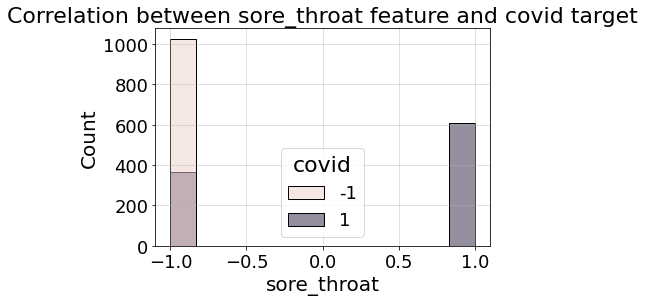

In [ ]:
#Plotting histogram for sore_throat and covid target variable
sns.histplot(data=train, x='sore_throat', hue="covid", line_kws={"linewidth": 3})
plt.grid(alpha = 0.5)
plt.title("Correlation between sore_throat feature and covid target")

Text(0.5, 1.0, 'Correlation between shortness_of_breath feature and covid target, out of patients with no sore_throat symptom')

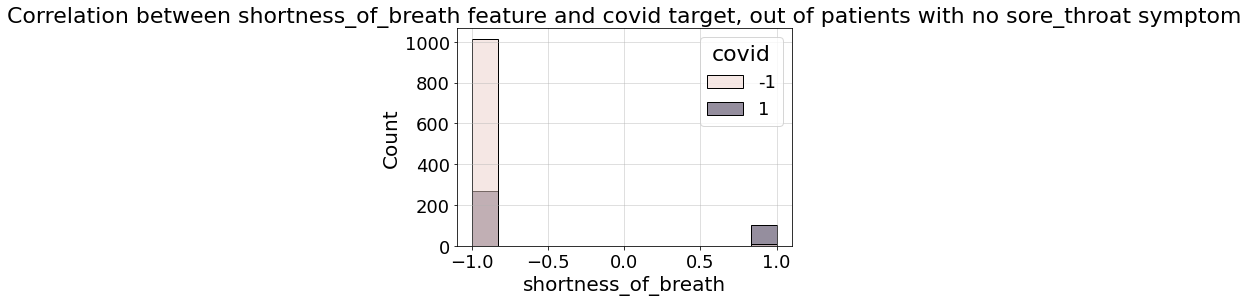

In [ ]:
#Plotting histogram for shortness_of_breath and covid target variable
train.drop(train[train.sore_throat == 1].index, inplace = True)
sns.histplot(data=train, x='shortness_of_breath', hue="covid", line_kws={"linewidth": 3})
plt.grid(alpha = 0.5)
plt.title("Correlation between shortness_of_breath feature and covid target, out of patients with no sore_throat symptom")

Text(0.5, 1.05, 'Bivariant relation between PCR_01, sore_throat and covid features')

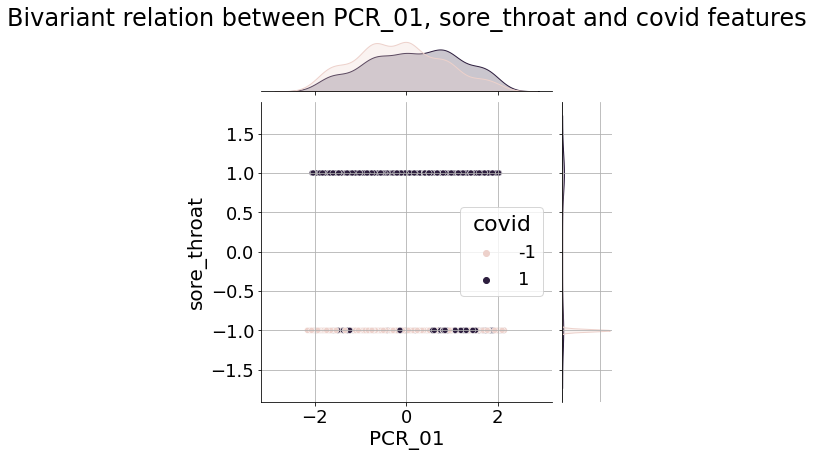

In [ ]:
#Plotting a jointplot for PCR_01 and sore_throat
train = copy(train_df_clean)
g = sns.jointplot(data = train[['PCR_01', 'sore_throat', 'covid']], x = 'PCR_01', y = 'sore_throat', hue = 'covid')
_ = g.ax_joint.grid()
plt.grid()
plt.suptitle("Bivariant relation between PCR_01, sore_throat and covid features", y=1.05)

Text(0.5, 1.0, 'Correlation between cough feature and covid target')

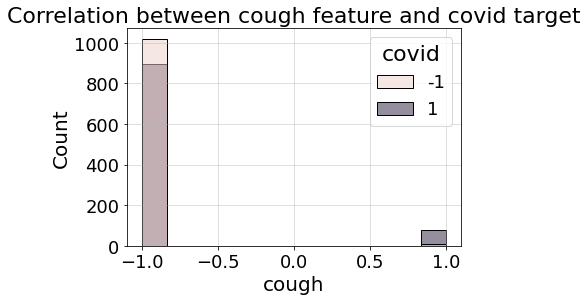

In [ ]:
#Plotting histogram for cough and covid target variable
sns.histplot(data=train, x='cough', hue="covid", line_kws={"linewidth": 3})
plt.grid(alpha = 0.5)
plt.title("Correlation between cough feature and covid target")

Text(0.5, 1.0, 'Correlation between sport_activity feature and covid target')

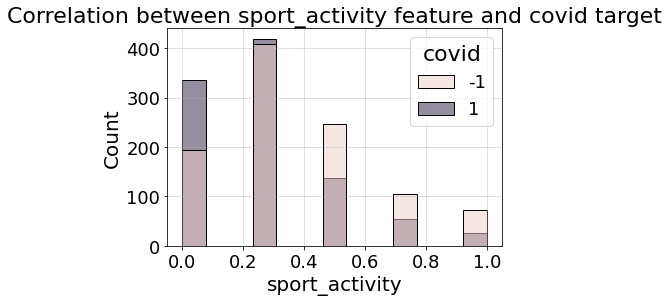

In [ ]:
#Plotting histogram for sport_activity and covid target variable
sns.histplot(data=train, x='sport_activity', hue="covid", line_kws={"linewidth": 3})
plt.grid(alpha = 0.5)
plt.title("Correlation between sport_activity feature and covid target")

###Q8

In [ ]:
#Calculating the 10 most highly correlated features to covid target variable
temp_train = copy(train_df_clean)
temp_train = temp_train.corr().covid.abs()
temp_train.sort_values(kind="quicksort", ascending=False).head(11)


covid                  1.000000
sore_throat            0.676008
shortness_of_breath    0.269202
sport_activity         0.222544
cough                  0.184765
PCR_01                 0.168945
PCR_04                 0.110006
sex                    0.098304
A+                     0.076868
O+                     0.068121
sugar_levels           0.050317
Name: covid, dtype: float64

###Q9

[Text(0.65, 0.9, 'sore_throat <= 0.0\nentropy = 0.999\nsamples = 2000\nvalue = [1027, 973]\nclass = No covid'),
 Text(0.4, 0.7, 'shortness_of_breath <= 0.0\nentropy = 0.832\nsamples = 1393\nvalue = [1026, 367]\nclass = No covid'),
 Text(0.2, 0.5, 'sport_activity <= 0.375\nentropy = 0.738\nsamples = 1282\nvalue = [1015, 267]\nclass = No covid'),
 Text(0.1, 0.3, 'PCR_01 <= 0.438\nentropy = 0.871\nsamples = 850\nvalue = [602, 248]\nclass = No covid'),
 Text(0.05, 0.1, 'entropy = 0.627\nsamples = 548\nvalue = [462, 86]\nclass = No covid'),
 Text(0.15, 0.1, 'entropy = 0.996\nsamples = 302\nvalue = [140, 162]\nclass = Covid'),
 Text(0.3, 0.3, 'A+ <= 0.0\nentropy = 0.26\nsamples = 432\nvalue = [413, 19]\nclass = No covid'),
 Text(0.25, 0.1, 'entropy = 0.36\nsamples = 278\nvalue = [259, 19]\nclass = No covid'),
 Text(0.35, 0.1, 'entropy = 0.0\nsamples = 154\nvalue = [154, 0]\nclass = No covid'),
 Text(0.6, 0.5, 'sport_activity <= 0.625\nentropy = 0.466\nsamples = 111\nvalue = [11, 100]\nclass 

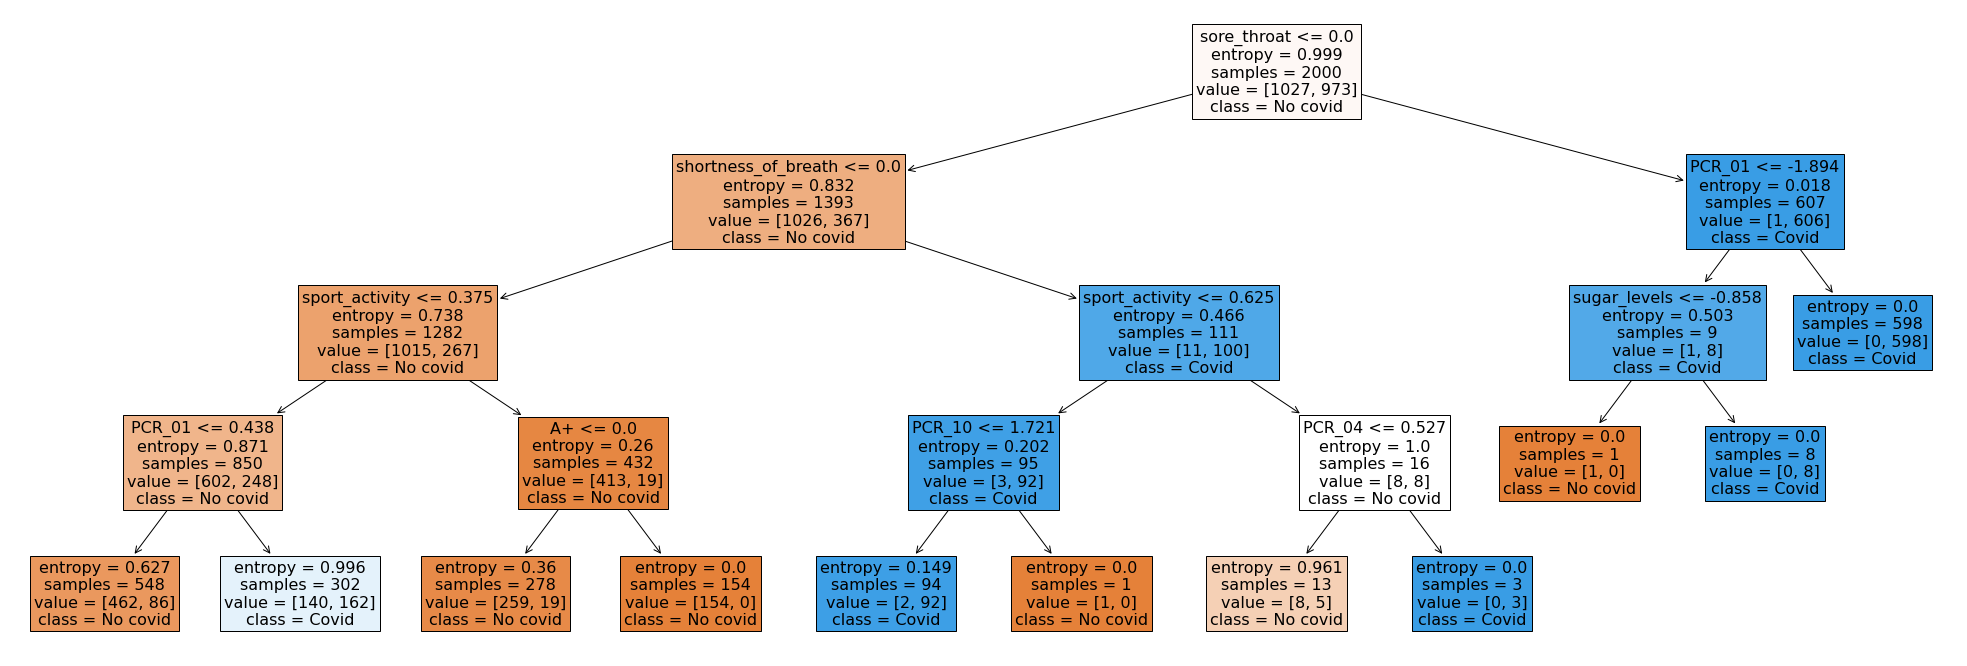

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

X_train = copy(train_df_clean).drop(columns=['risk', 'covid', 'spread'])
Y_train = copy(train_df_clean).covid

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=4)

# Train Decision Tree Classifer
classifier = clf.fit(X=X_train, y=Y_train)

# Visualizing the decision tree
plt.figure(figsize=(35,12))

tree.plot_tree(classifier, 
               feature_names=X_train.columns,  
               class_names=['No covid', 'Covid'],
               fontsize=16,
               filled=True
               )

In [ ]:
#Calculating training accuracy
train_score = classifier.score(X=X_train, y=Y_train)

print("Accuracy:",train_score)

Accuracy: 0.874


##Model Selection

###Q11

In [ ]:
from sklearn.model_selection import GridSearchCV

#Creating a temporary dataframe for training
temp_train = copy(train_df_clean)
temp_train.drop('risk' , axis = 1 , inplace = True)
temp_train.drop('covid' , axis = 1 , inplace = True)
temp_train.drop('spread' , axis = 1 , inplace = True)
temp_labels = copy(train_df_clean.covid.values)

max_depths = list(range(1,11,1))
min_samples = list(range(1,5,1)) + list(range(5,200,10))
params = {"criterion" : ["entropy"], "max_depth" : max_depths, "min_samples_leaf" : min_samples}
tree = DecisionTreeClassifier()

#Creating and fitting the grid search model
clf = GridSearchCV(estimator = tree, param_grid = params, cv = 8, return_train_score = True)
clf.fit(temp_train, temp_labels)

validation_means = clf.cv_results_["mean_test_score"]
training_means = clf.cv_results_["mean_train_score"]


In [ ]:
#Plotting heatmaps
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.heatmap(validation_means.reshape(len(max_depths), len(min_samples)), vmin = 0.7, vmax = 1, \
                  xticklabels = min_samples, yticklabels = max_depths, annot = True, cbar = True)
plt.set_xlabel('Min Samples Leaf', fontsize = 20)
plt.set_ylabel('Max Depth', fontsize = 20)
plt.set_title('Mean Validation Accuracy', fontsize = 40)

In [ ]:
plt = sns.heatmap(training_means.reshape(len(max_depths), len(min_samples)), vmin = 0.7, vmax = 1, \
                  xticklabels = min_samples, yticklabels = max_depths, annot = True, cbar = True)
plt.set_xlabel('Min Samples Leaf', fontsize = 20)
plt.set_ylabel('Max Depth', fontsize = 20)
plt.set_title('Mean Training Accuracy', fontsize = 40)

In [ ]:
print(clf.best_params_)

###Q12

In [ ]:
X_train = copy(train_df_clean).drop(columns=['risk', 'covid', 'spread'])
Y_train = copy(train_df_clean).covid
X_test = copy(test_df_clean).drop(columns=['risk', 'covid', 'spread'])
Y_test = copy(test_df_clean).covid

# Create Decision Tree classifer object with the optimal hyperparameters
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth = 8, min_samples_leaf = 15)

# Train Decision Tree Classifer
classifier = clf.fit(X=X_train, y=Y_train)

print("Test score for this model is "+ str(clf.score(X_test, Y_test)))

#Part 3: Linear SVM and the Polynomial Kernel

##Implementation of the Loss and Its Gradient

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        # TODO: complete the loss calculation
        hinge_max = np.maximum(0, 1 - hinge_inputs)
        loss = norm**2 + C * (np.sum(hinge_max))

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        margins = (X.dot(w) + b).reshape(-1, 1)
        margins = np.multiply(margins, y.reshape(-1, 1))
        #Subtracting 1 from all values of vector so we can use sign function
        f = np.sign(margins - 1)
        #Turning ones to zeros to fit function definition
        f = np.minimum(f, 0)

        g_w = 2 * w + np.sum(np.multiply((np.multiply(f, y.reshape(-1, 1))), X), axis = 0) * C 
        g_b = np.sum(np.multiply(f, y)) * C

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        
        y_pred = np.sign((X.dot(self.w) + self.b))

        return y_pred


##Loading a Synthetic Dataset for Basic Experiments

###Q13

In [ ]:
#Creating the moons dataset
from sklearn.datasets import make_moons
X_moons, y_moons = make_moons(n_samples=1000, shuffle=True, noise=0.05, random_state = 122)
y_moons = ((2 * y_moons) - 1)[:, None]
print(f"{X_moons.shape}, {y_moons.shape}")
plt.figure(), plt.grid(alpha=0.5), plt.title("Synthetic moon dataset"), plt.xlabel("feature 1"), plt.ylabel("feature 2")
_ = sns.scatterplot(x=X_moons[:, 0], y=X_moons[:, 1], hue=y_moons[:, 0])

##Verifying Your Implementation: Numerical vs. Analytical Gradient

In [ ]:
#Provided functions
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


###Q14

In [ ]:
#Generating plot
compare_gradients(X_moons, y_moons, deltas=np.logspace(-9, -1, 12))

##Solving Soft SVM Problems Using Stochastic Gradient Descent (SGD)

###Q15

In [ ]:
#Creating and training the classifier
clf = SoftSVM(C=1, lr=2e-3)
losses, accuracies = clf.fit_with_logs(X_moons, y_moons, max_iter=2000)

#Plotting the results
plt.figure(figsize=(13, 6))
plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Soft SVM Model Losses Over Number of SGD Iterations", fontsize = 20)
plt.semilogy(losses), plt.xlabel("Iteration"), plt.ylabel("Loss")
plt.tight_layout()

In [ ]:
#Plotting more results
plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Soft SVM Model Accuracy Over Number of SGD Iterations", fontsize = 20)
plt.plot(accuracies), plt.xlabel("Iteration"), plt.ylabel("Accuracy")
plt.tight_layout()

In [ ]:
#Visualizing the decision regions
visualize_clf(clf, X_moons, y_moons, "Soft SVM Decision Regions", "feature 1", "feature 2")

#Calculating best results
maximal_accuracy = np.max(accuracies)
maximal_accuracy_index = accuracies.index(maximal_accuracy)
minimal_loss = np.min(losses)
minimal_loss_index = losses.index(minimal_loss)
print("max accuracy is "+str(maximal_accuracy)+", in iteration "+str(maximal_accuracy_index))
print("min loss is "+str(minimal_loss)+", in iteration "+str(minimal_loss_index))

##Using a feature mapping

###Q16

In [ ]:
#Creating temporary dataframe
train_temp = train_df_clean[['spread' , 'PCR_05' , 'sugar_levels']].copy()

In [ ]:
#Creating a jointplot for sugar_levels, PCR_05 and spread target variable
g = sns.jointplot(data = train_temp , x = 'PCR_05' , y = 'sugar_levels' , hue = 'spread')
plt.grid()
g.fig.suptitle('Jointplot of PCR_05 and sugar_levels according to spread' , y = 1.0, fontsize = 15)

###Q17

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X = np.array(train_temp[['PCR_05', 'sugar_levels']])
y = np.array(train_temp[['spread']])
accuracies = []

#Training the pipeline model 5 times
for i in range(5):
  svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('SVM', SoftSVM(C=1e4, lr=1e-3, batch_size=32))])
  svm_clf.fit(X, y, SVM__max_iter=10000)
  accuracies.append(svm_clf.score(X , y))
  visualize_clf(svm_clf, X, y, 'Soft SVM With Feature Mapping', 
                  'PCR_05', 'sugar_levels', marker_size = 50)

In [ ]:
#Printing training accuracies and other statistics
print(f'Training accuracies: {accuracies}')
print(f'Mean: {np.mean(accuracies):.3f}')
print(f'Std: {np.std(accuracies):.3f}')

###Q18

In [ ]:
from sklearn.model_selection import cross_validate

#Choosing C values and preparing arrays for storing results
c_values = np.logspace(-5, 10 , num = 20)
train_accuracy = []
validation_accuracy = []
train_std = []
validation_std = []

#Preforming cross validation 10-folds with different C values
for c in c_values:
  cv_results = cross_validate(Pipeline([('feature_mapping', PolynomialFeatures(2)),
 ('SVM', SoftSVM(C=c, lr=1e-3, batch_size=32))]), X, y, cv=10 , return_train_score = True)
  validation_accuracy.append(np.mean(cv_results['test_score']))
  train_accuracy.append(np.mean(cv_results['train_score']))
  train_std.append(np.std(cv_results['test_score']))
  validation_std.append(np.std(cv_results['train_score']))

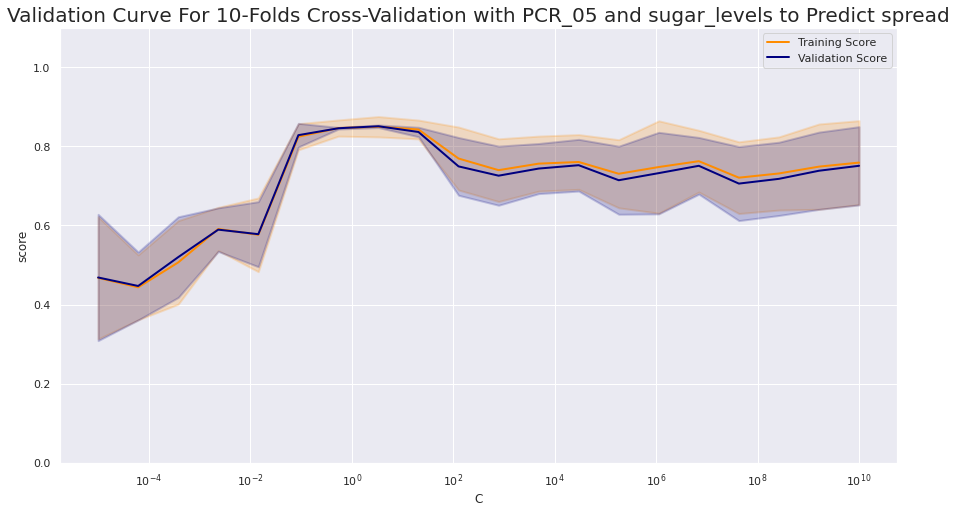

best c value is 3.359818286283781 , its train accuracy is 0.8497777777777777and its validation accuracy is 0.851


In [ ]:
#Plotting the validation curve  
plt.title("Validation Curve For 10-Folds Cross-Validation with PCR_05 and sugar_levels to Predict spread", fontsize = 20)
plt.xlabel('C')
plt.ylabel('score')
plt.ylim(0.0, 1.1)
plt.semilogx(
    c_values, train_accuracy, label="Training Score", color="darkorange", lw=2
    )
plt.fill_between(
    c_values,
    np.subtract(np.array(train_accuracy), np.array(train_std)),
    np.add(np.array(train_accuracy), np.array(train_std)),
    alpha=0.2,
    color="darkorange",
    lw=2,
    )
plt.semilogx(
    c_values, validation_accuracy, label="Validation Score", color="navy", lw=2
    )
plt.fill_between(
    c_values,
    np.subtract(np.array(validation_accuracy), np.array(validation_std)),
    np.add(np.array(validation_accuracy), np.array(validation_std)),
    alpha=0.2,
    color="navy",
    lw=2,
    )
plt.legend(loc="best")
plt.xscale('log')
plt.show()

#Calculating training and validation accuracies, and the optimal value for k
best_validation_accuracy = np.max(validation_accuracy)
best_validation_accuracy_index = validation_accuracy.index(best_validation_accuracy)
train_accuracy = train_accuracy[best_validation_accuracy_index]
best_c = c_values[best_validation_accuracy_index]
print("best c value is "+str(best_c)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

###Q19

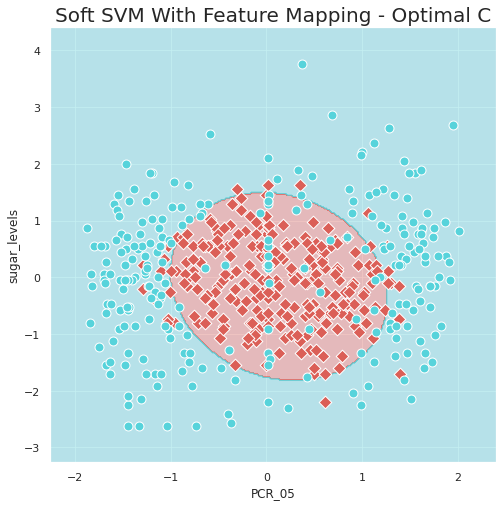

Test accuracy = 0.878


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
#Creating temporary dataframes
test_temp = copy(test_df_clean[['spread' , 'PCR_05' , 'sugar_levels']])
train_temp = copy(test_df_clean[['spread' , 'PCR_05' , 'sugar_levels']])
test_X = test_temp[['PCR_05', 'sugar_levels']]
test_y = test_temp[['spread']]
train_X = np.array(train_temp[['PCR_05', 'sugar_levels']])
train_y = np.array(train_temp[['spread']])

#Preforming pipeline on all training samples
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('SVM', SoftSVM(C=best_c, lr=1e-3, batch_size=32))])
svm_clf.fit(train_X, train_y, SVM__max_iter=10000)
visualize_clf(svm_clf, train_X, train_y, 'Soft SVM With Feature Mapping - Optimal C', 
                  'PCR_05', 'sugar_levels')
print(f'Test accuracy = {svm_clf.score(test_X , test_y)}')

#Part 4: The RBF kernel

###Q20

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


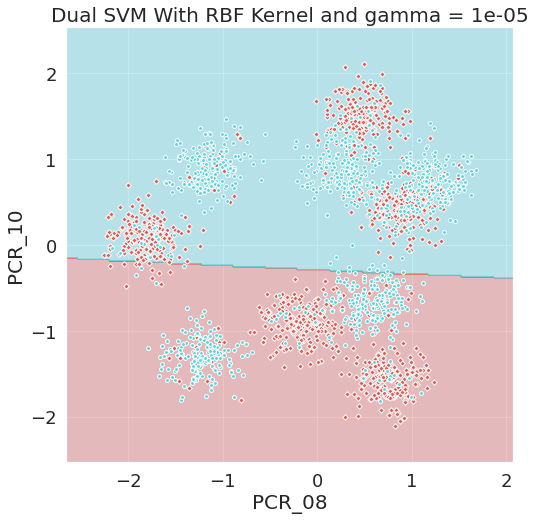

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


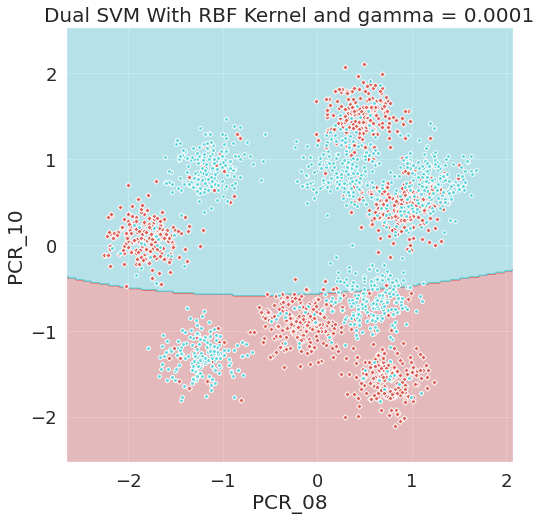

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


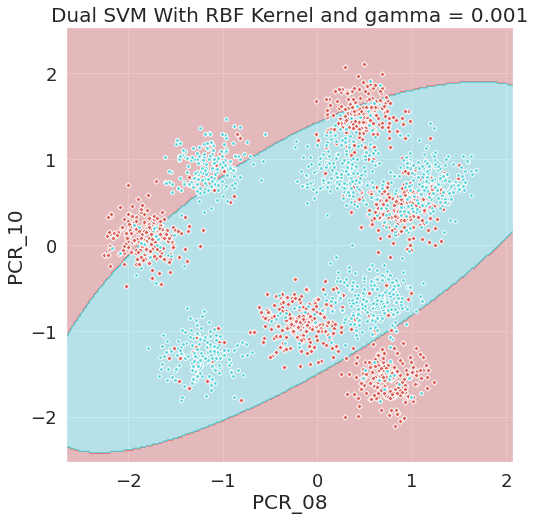

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


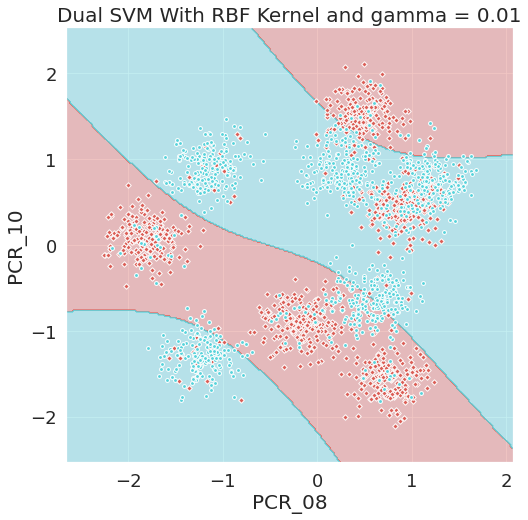

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


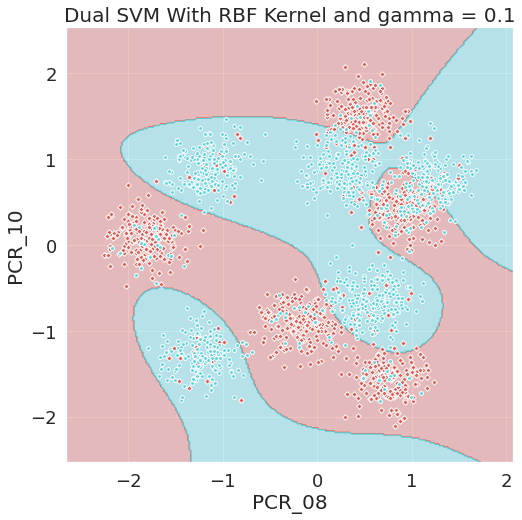

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


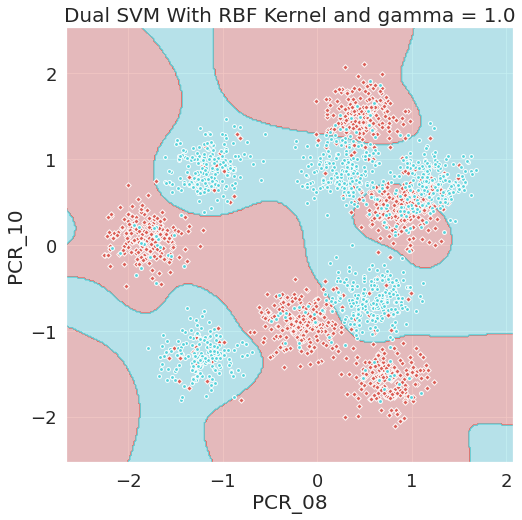

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


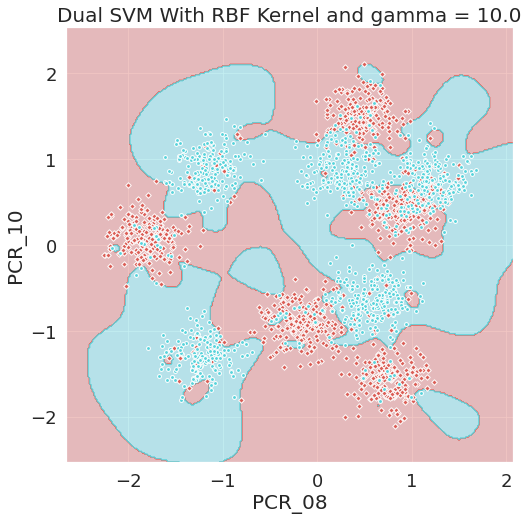

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


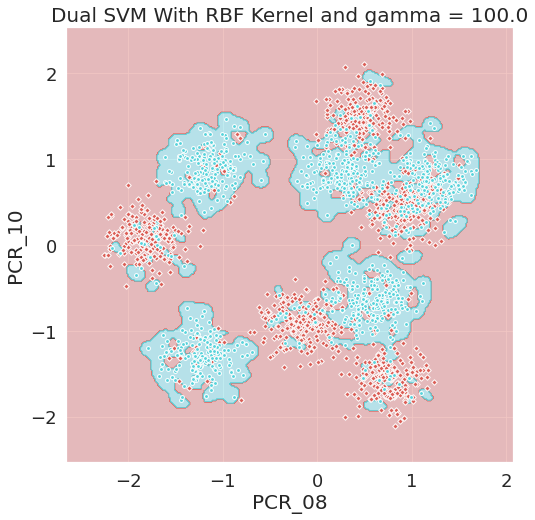

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


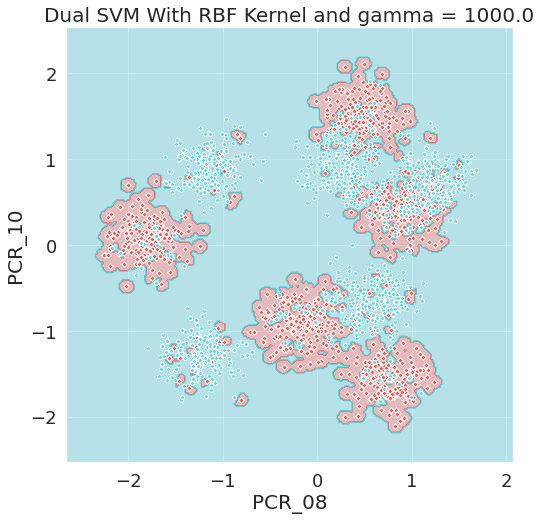

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


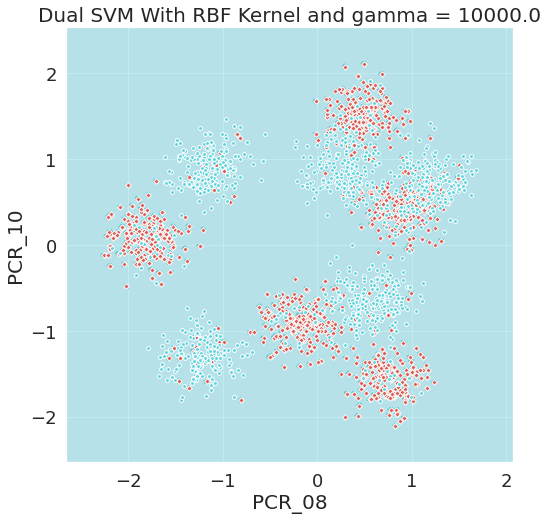

In [ ]:
from sklearn.svm import SVC

#Creating temporary dataframes
train_rbf = copy(train_df_clean[['PCR_08' , 'PCR_10' , 'risk']])
rbf_X = np.array(train_rbf[['PCR_08', 'PCR_10']])
rbf_y = np.array(train_rbf[['risk']])

#Training and plotting 10 models
for gamma in np.logspace(-5, 4, 10):
  clf = SVC(gamma=gamma , C=1e4)
  clf.fit(rbf_X , rbf_y)
  visualize_clf(clf, rbf_X, rbf_y, f'Dual SVM With RBF Kernel and gamma = {gamma}', 
                  'PCR_08', 'PCR_10', marker_size = 15)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


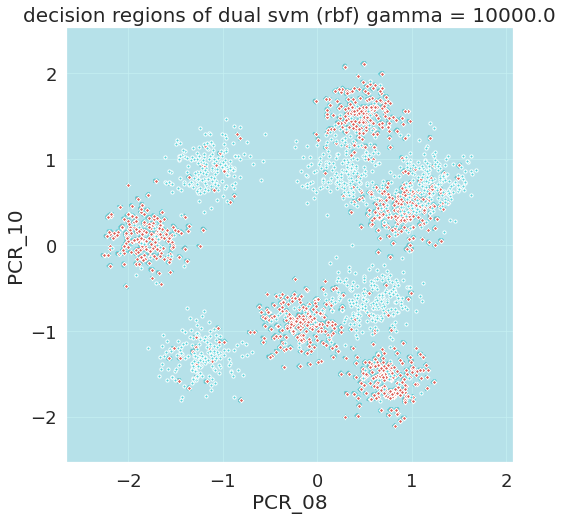

In [ ]:
#Visualizing the decision regions of the model with gamma = 10000
visualize_clf(SVC(gamma=1e4 , C=1e4).fit(rbf_X , rbf_y), rbf_X, rbf_y, f'decision regions of dual svm (rbf) gamma = {gamma}', 
                  'PCR_08', 'PCR_10' , marker_size = 10)

###Q22

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#Creating a temporary dataframe for training
temp_train = np.array(copy(train_df_clean[['PCR_08', 'PCR_10']]))
temp_labels = np.array(copy(train_df_clean[['risk']]))

#Preforming cross-validation 8-folds
c_values = np.logspace(-4, 3, 8)
gamma_values = np.logspace(-4, 3, 8)
parameters = {'C':c_values , 'gamma':gamma_values}
clf = GridSearchCV(SVC(), parameters , cv = 8 , return_train_score = True)
clf.fit(temp_train, temp_labels)
validation_means = clf.cv_results_["mean_test_score"]
training_means = clf.cv_results_["mean_train_score"]

Text(0.5, 1.0, 'Mean Validation Accuracy')

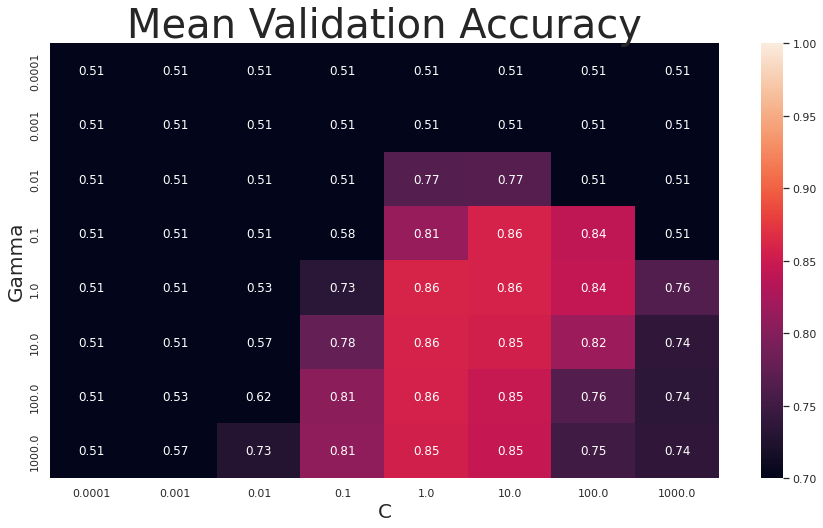

In [ ]:
#Plotting heatmaps
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.heatmap(validation_means.reshape(len(c_values), len(gamma_values)), vmin = 0.7, vmax = 1, \
                  xticklabels = c_values, yticklabels = gamma_values, annot = True, cbar = True)
plt.set_xlabel('C', fontsize = 20)
plt.set_ylabel('Gamma', fontsize = 20)
plt.set_title('Mean Validation Accuracy', fontsize = 40)

Text(0.5, 1.0, 'Mean Training Accuracy')

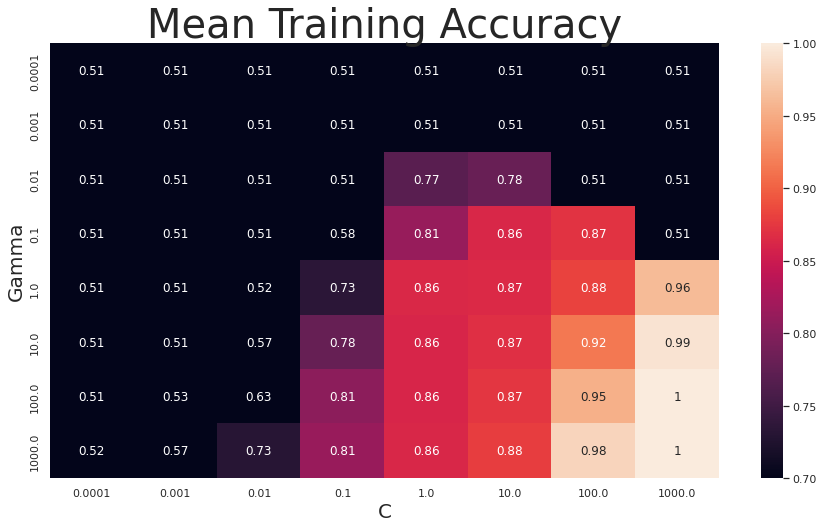

In [ ]:
#Plotting more heatmaps
plt = sns.heatmap(training_means.reshape(len(c_values), len(gamma_values)), vmin = 0.7, vmax = 1, \
                  xticklabels = c_values, yticklabels = gamma_values, annot = True, cbar = True)
plt.set_xlabel('C', fontsize = 20)
plt.set_ylabel('Gamma', fontsize = 20)
plt.set_title('Mean Training Accuracy', fontsize = 40)

In [ ]:
#Printing best parameters
print(clf.best_params_)

{'C': 1.0, 'gamma': 1.0}


###Q23

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


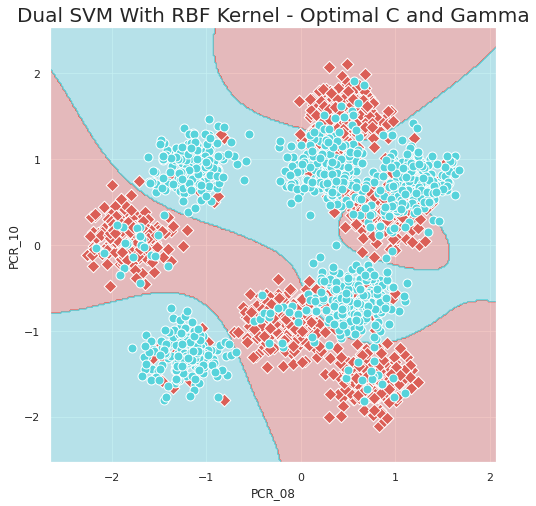

In [ ]:
#Training model with optimal hyperparameters
clf = SVC(gamma= 1, C=1)
clf.fit(temp_train, temp_labels)
visualize_clf(clf, temp_train, temp_labels, 'Dual SVM With RBF Kernel - Optimal C and Gamma', 
                  'PCR_08', 'PCR_10' )

In [ ]:
#Calculating test accuracy
test_rbf = copy(test_df_clean[['PCR_08' , 'PCR_10' , 'risk']])
test_rbf_X = np.array(test_rbf[['PCR_08', 'PCR_10']])
test_rbf_y = np.array(test_rbf[['risk']])

print(f'Test accuracy = {clf.score(test_rbf_X , test_rbf_y)}')

Test accuracy = 0.842


# How to download from Colab?

In [ ]:
from google.colab import files
outputPath = "saved_file.csv"
dataset.to_csv(outputPath)
files.download(outputPath) 